In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import os
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, MaxPooling1D, AveragePooling1D, Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, BatchNormalization, LeakyReLU, LSTM, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import random

Using TensorFlow backend.


In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My Drive/Colab Notebooks/models

/content/gdrive/My Drive/Colab Notebooks/models


In [0]:
batch_size = 16
# target class
num_classes = 10

epochs = 25

In [0]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# 1. y_train -> to_categorical -> categorical dataset -> Loss: categorical_crossentropy
# Last dense layer: 10

# 2. y_train -> Loss: sparse_categorical_crossentropy
# Last dense layer:10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
import pprint

use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

with tf.Session(TF_MASTER) as session:
  print ('List of devices:')
  pprint.pprint(session.list_devices())

List of devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 10737950758017845870),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16306264993676103659),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15531945719677852956),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4732859251488557283),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16253089559884349291),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9381142900149207831),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17613907328943659196),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5014126443857272409),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 14288040247651492716),
 _DeviceAttributes(/job:

In [0]:
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: 10.0.56.82:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.0.56.82:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10737950758017845870)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15531945719677852956)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4732859251488557283)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16253089559884349291)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:

In [0]:
# Model specific parameters

# TPU address
tpu_address = TF_MASTER

# Number of epochs
epochs = 25

네트워크를 직접 설계해 보세요!

In [0]:
def CNN_model():
  # for example,
  n_kernels = 32
  input_layer = layers.Input(shape=[32,32,3])
  
  x = Conv2D(n_kernels, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid' )(input_layer)
  x = Conv2D(n_kernels*2, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)
  
  x = Conv2D(n_kernels*2, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
  x = Conv2D(n_kernels*4, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)

  x = Conv2D(n_kernels*4, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
  x = Conv2D(n_kernels*8, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
  x = BatchNormalization()(x)
  
  x = GlobalAveragePooling2D()(x)
  last = Dense(10, activation='softmax', kernel_initializer='glorot_uniform')(x)
  
  return Model(input_layer, last)

In [0]:
with strategy.scope():
  opti = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model = CNN_model()
  
  model.compile(loss='categorical_crossentropy',
        optimizer=opti,
        metrics=['acc'])
  
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
______________________________________________

In [0]:
# Let's train the model using RMSprop
history = model.fit(x_train, y_train,
    batch_size=128, steps_per_epoch=390, epochs=25)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
390/390 [==============================] - 5s 12ms/step - loss: 1.4452 - acc: 0.4909
Epoch 2/25
390/390 [==============================] - 3s 8ms/step - loss: 1.0275 - acc: 0.6426
Epoch 3/25
390/390 [==============================] - 3s 8ms/step - loss: 0.8383 - acc: 0.7089
Epoch 4/25
390/390 [==============================] - 3s 8ms/step - loss: 0.7094 - acc: 0.7547
Epoch 5/25
390/390 [==============================] - 3s 8ms/step - loss: 0.6127 - acc: 0.7867
Epoch 6/25
390/390 [==============================] - 3s 8ms/step - loss: 0.5311 - acc: 0.8153
Epoch 7/25
390/390 [==============================] - 3s 8ms/step - loss: 0.4499 - acc: 0.8429
Epoch 8/25
390/390 [==============================] - 3s 8ms/step - loss: 0.3833 - acc: 0.8661
Epoch 9/25
390/390 [==============================] - 3s 9ms/step - loss: 0.3213 - acc: 0.8873
Epoch 10/25
390/390 [=============================

In [0]:
epochs_range = range(25)
training_loss = history.history['loss']
training_acc = history.history['acc']

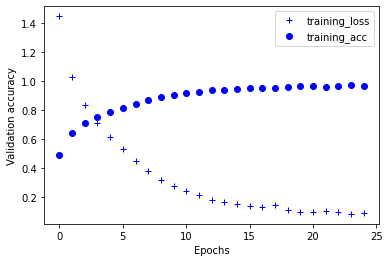

In [0]:
import matplotlib.pyplot as plt

plt.plot(epochs_range, training_loss, 'b+', label='training_loss')
# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs_range, training_acc, 'bo', label='training_acc')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()

plt.show()